In [2]:
import os
# set working directory to root 
os.chdir('..')
os.getcwd()

'/home/qiangzibro/2021-math-model-code'

In [4]:
# Author: QiangZiBro
# Time: 2021-10-14
# Contact: Github/QiangZiBro

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import warnings
# visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.rcParams['font.family'] = ['Noto Serif CJK JP']
# %matplotlib inline

import sys
import os

from pprint import pprint

if not os.path.exists("results"):
    os.mkdir("results")

warnings.filterwarnings("ignore")
FIGSIZE = (30, 25)
FORMAT = "pdf"

## 数据加载工具

In [5]:
PLACES = ['A', 'B', 'C', 'A1', 'A2', 'A3']
POLLUTIONS = ["SO2", "NO2", "PM10", "PM2.5", "O3", "CO"]
TYPES = [0, 1, 2]

from common.io import load

def find_pollution_columns(data):
    result = []
    for name in POLLUTIONS:
        for i in data.columns:
            if i.startswith(name):
                result.append(i)
    return result


In [6]:
data = load()
data['A'][0].describe()

Use 3 threads to read table...
Done, cost 113.02532005310059s


,近地2米温度（℃）,地表温度（K）,比湿（kg/kg）,湿度（%）,近地10米风速（m/s）,近地10米风向（°）,雨量（mm）,云量,边界层高度（m）,大气压（Kpa）,...,潜热通量（W/m²）,长波辐射（W/m²）,短波辐射（W/m²）,地面太阳能辐射（W/m²）,SO2小时平均浓度(μg/m³),NO2小时平均浓度(μg/m³),PM10小时平均浓度(μg/m³),PM2.5小时平均浓度(μg/m³),O3小时平均浓度(μg/m³),CO小时平均浓度(mg/m³)
count,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,...,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,2.541600e+04,25416.000000
mean,24.941367,301.906307,0.013027,59.271910,3.927604,123.315270,0.391002,0.460008,674.963830,101.190651,...,16.962561,395.170426,215.264752,258.667851,8.095342,57.976588,33.951973,27.052738,3.289282e+01,0.298747
std,5.972074,8.613403,0.005130,16.499209,1.696326,79.249468,1.991600,0.326640,450.299871,0.651010,...,19.651134,49.883333,276.857248,332.679032,7.977947,34.019993,28.272897,24.408726,3.549418e+01,0.231951
min,3.413970,275.448000,0.000647,8.546440,0.012006,0.002380,0.000000,0.000000,19.774900,99.664800,...,-2.089550,230.671000,0.000000,0.000000,0.003020,7.685690,0.538817,0.410555,2.052830e-14,0.089578
25%,21.211475,296.083750,0.009315,47.224525,2.711615,56.523125,0.000000,0.150826,330.467500,100.631000,...,1.073412,360.149500,0.000000,0.000000,2.695410,31.543275,11.532400,7.621767,4.135275e+00,0.163849
50%,25.947200,301.986000,0.013289,59.458100,3.834030,130.049500,0.000000,0.439354,549.772000,101.190000,...,6.617565,407.791000,31.445800,37.786050,5.527160,50.482150,25.355650,17.991850,2.122600e+01,0.229687
75%,29.278250,307.547000,0.017701,72.739450,5.059253,172.048250,0.000000,0.774837,969.257750,101.689250,...,30.767725,435.506750,422.042750,507.138000,10.960800,78.987875,49.329875,41.128100,5.217420e+01,0.349102
max,37.471400,323.987000,0.023138,99.149200,12.712100,359.995000,86.203000,1.000000,2465.210000,102.925000,...,77.258600,491.217000,889.015000,1068.260000,134.948000,610.844000,253.909000,190.873000,4.151800e+02,3.214280


## 一键报告（仅供参考）

In [4]:
# import pandas_profiling
# from pathlib import Path
# for p in PLACES:
#     for i in range(3):
#         profile = data[p][i].profile_report(title = f"{p}_{i}")
#         profile.to_file(output_file = Path(f"./{p}_{i}_report.html"))

In [185]:
# import sweetviz as sv
# my_report = sv.analyze(data['A'][2])
# my_report.show_html()

# for p in PLACES:
#     for i in range(3):
#         my_report = sv.analyze(data[p][i])
#         my_report.show_html(Path(f"./sv_{p}_{i}_report.html"))

In [7]:
print(data.keys())
print(data['A'].keys())
# for p in PLACES:
#     for i in range(3): 
#         print(data[p][i].min())

dict_keys(['A', 'B', 'C', 'A1', 'A2', 'A3'])
dict_keys([0, 1, 2])


# 数据处理
## 异常值分析

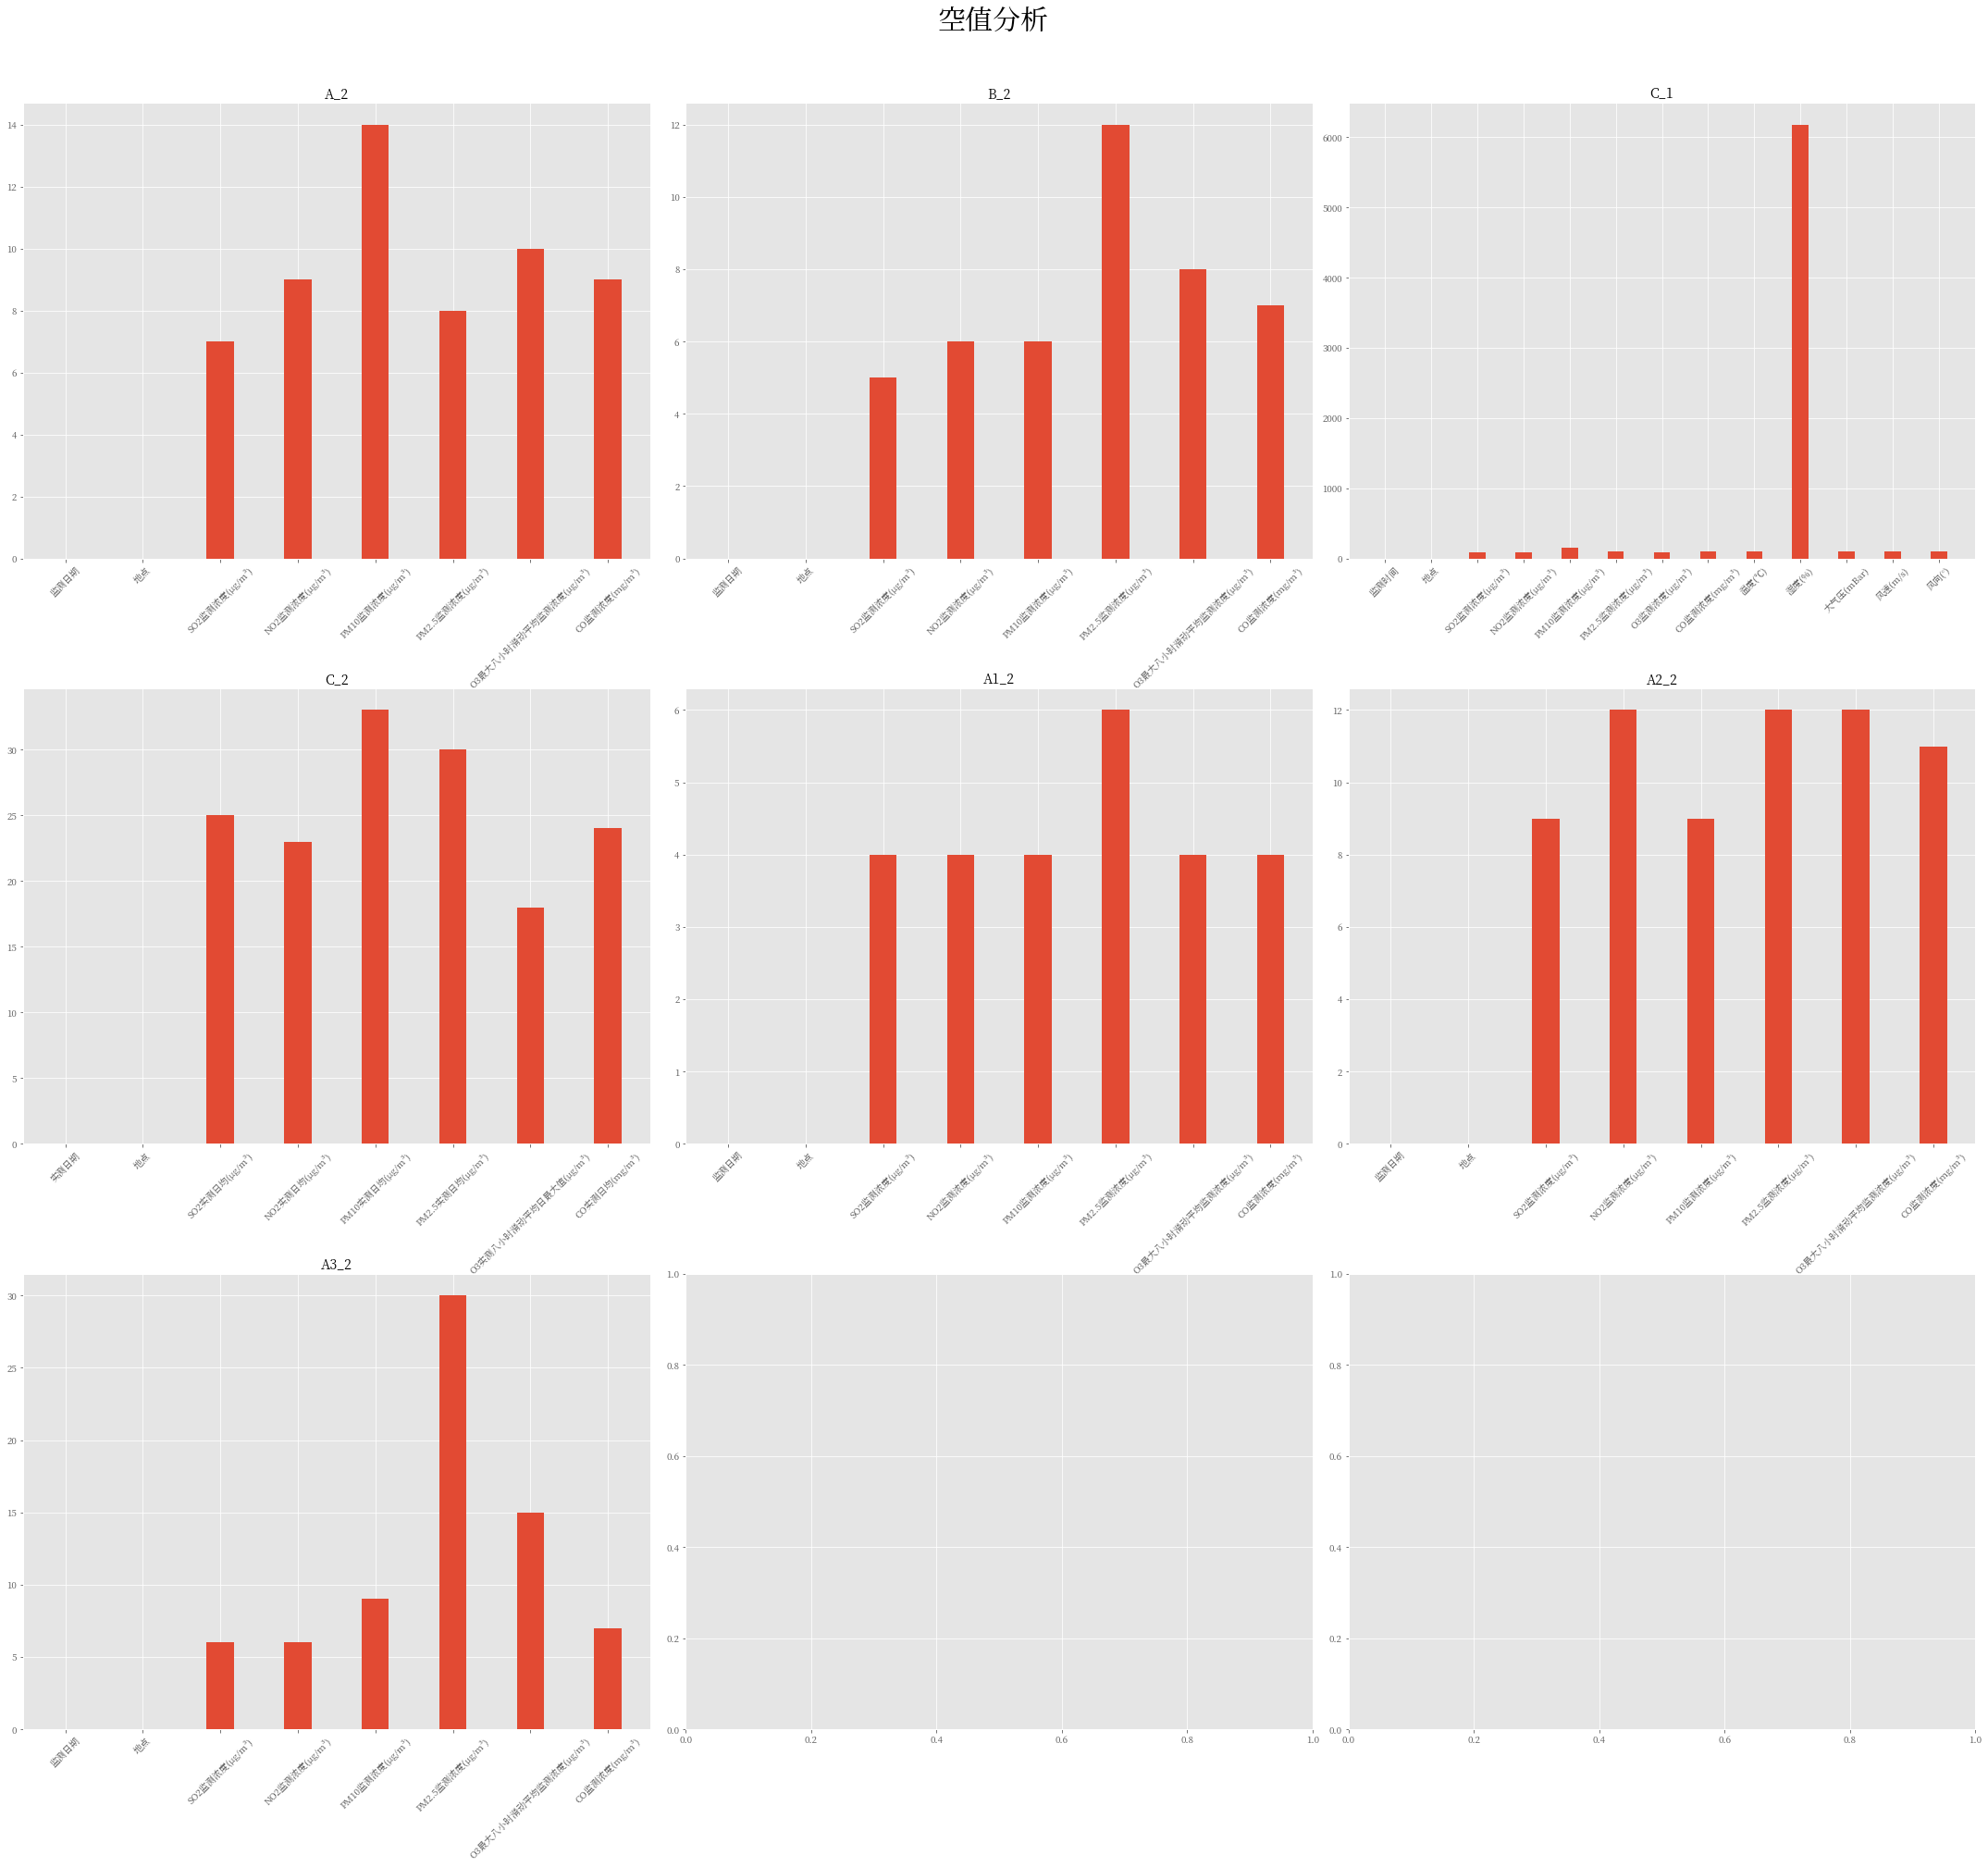

In [8]:
def null_values_analysis(data):
    NULL_COUNTS = {}
    NULL_TABLES = []
    for p in PLACES:
        for t in TYPES:  
            if data[p][t].isnull().sum().sum():
                NULL_COUNTS.update({p+"_"+str(t):data[p][t].isnull().sum()})
                NULL_TABLES.append((p, t))
    return NULL_COUNTS, NULL_TABLES

def null_values_analysis_plot(null_table):
    fig, axs = plt.subplots(3, 3, figsize=FIGSIZE)
    fig.tight_layout(h_pad=12)
    fig.suptitle('空值分析', size=30, y=1.05)
    
    for i, (k,v) in enumerate(null_table.items()):
        axs[i//3][i%3].bar(v.keys(), v, 0.35)
        axs[i//3][i%3].set_title(k)
        axs[i//3][i%3].set_xticklabels(labels=v.keys(),rotation=45)
        axs[i//3][i%3].grid(True)

    font = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 16,
            }

    plt.savefig("results/nan_value_analysis."+FORMAT, format=FORMAT)
    # plt.close()
null_table, table_names = null_values_analysis(data)
null_values_analysis_plot(null_table)

In [9]:
table_names

[('A', 2), ('B', 2), ('C', 1), ('C', 2), ('A1', 2), ('A2', 2), ('A3', 2)]

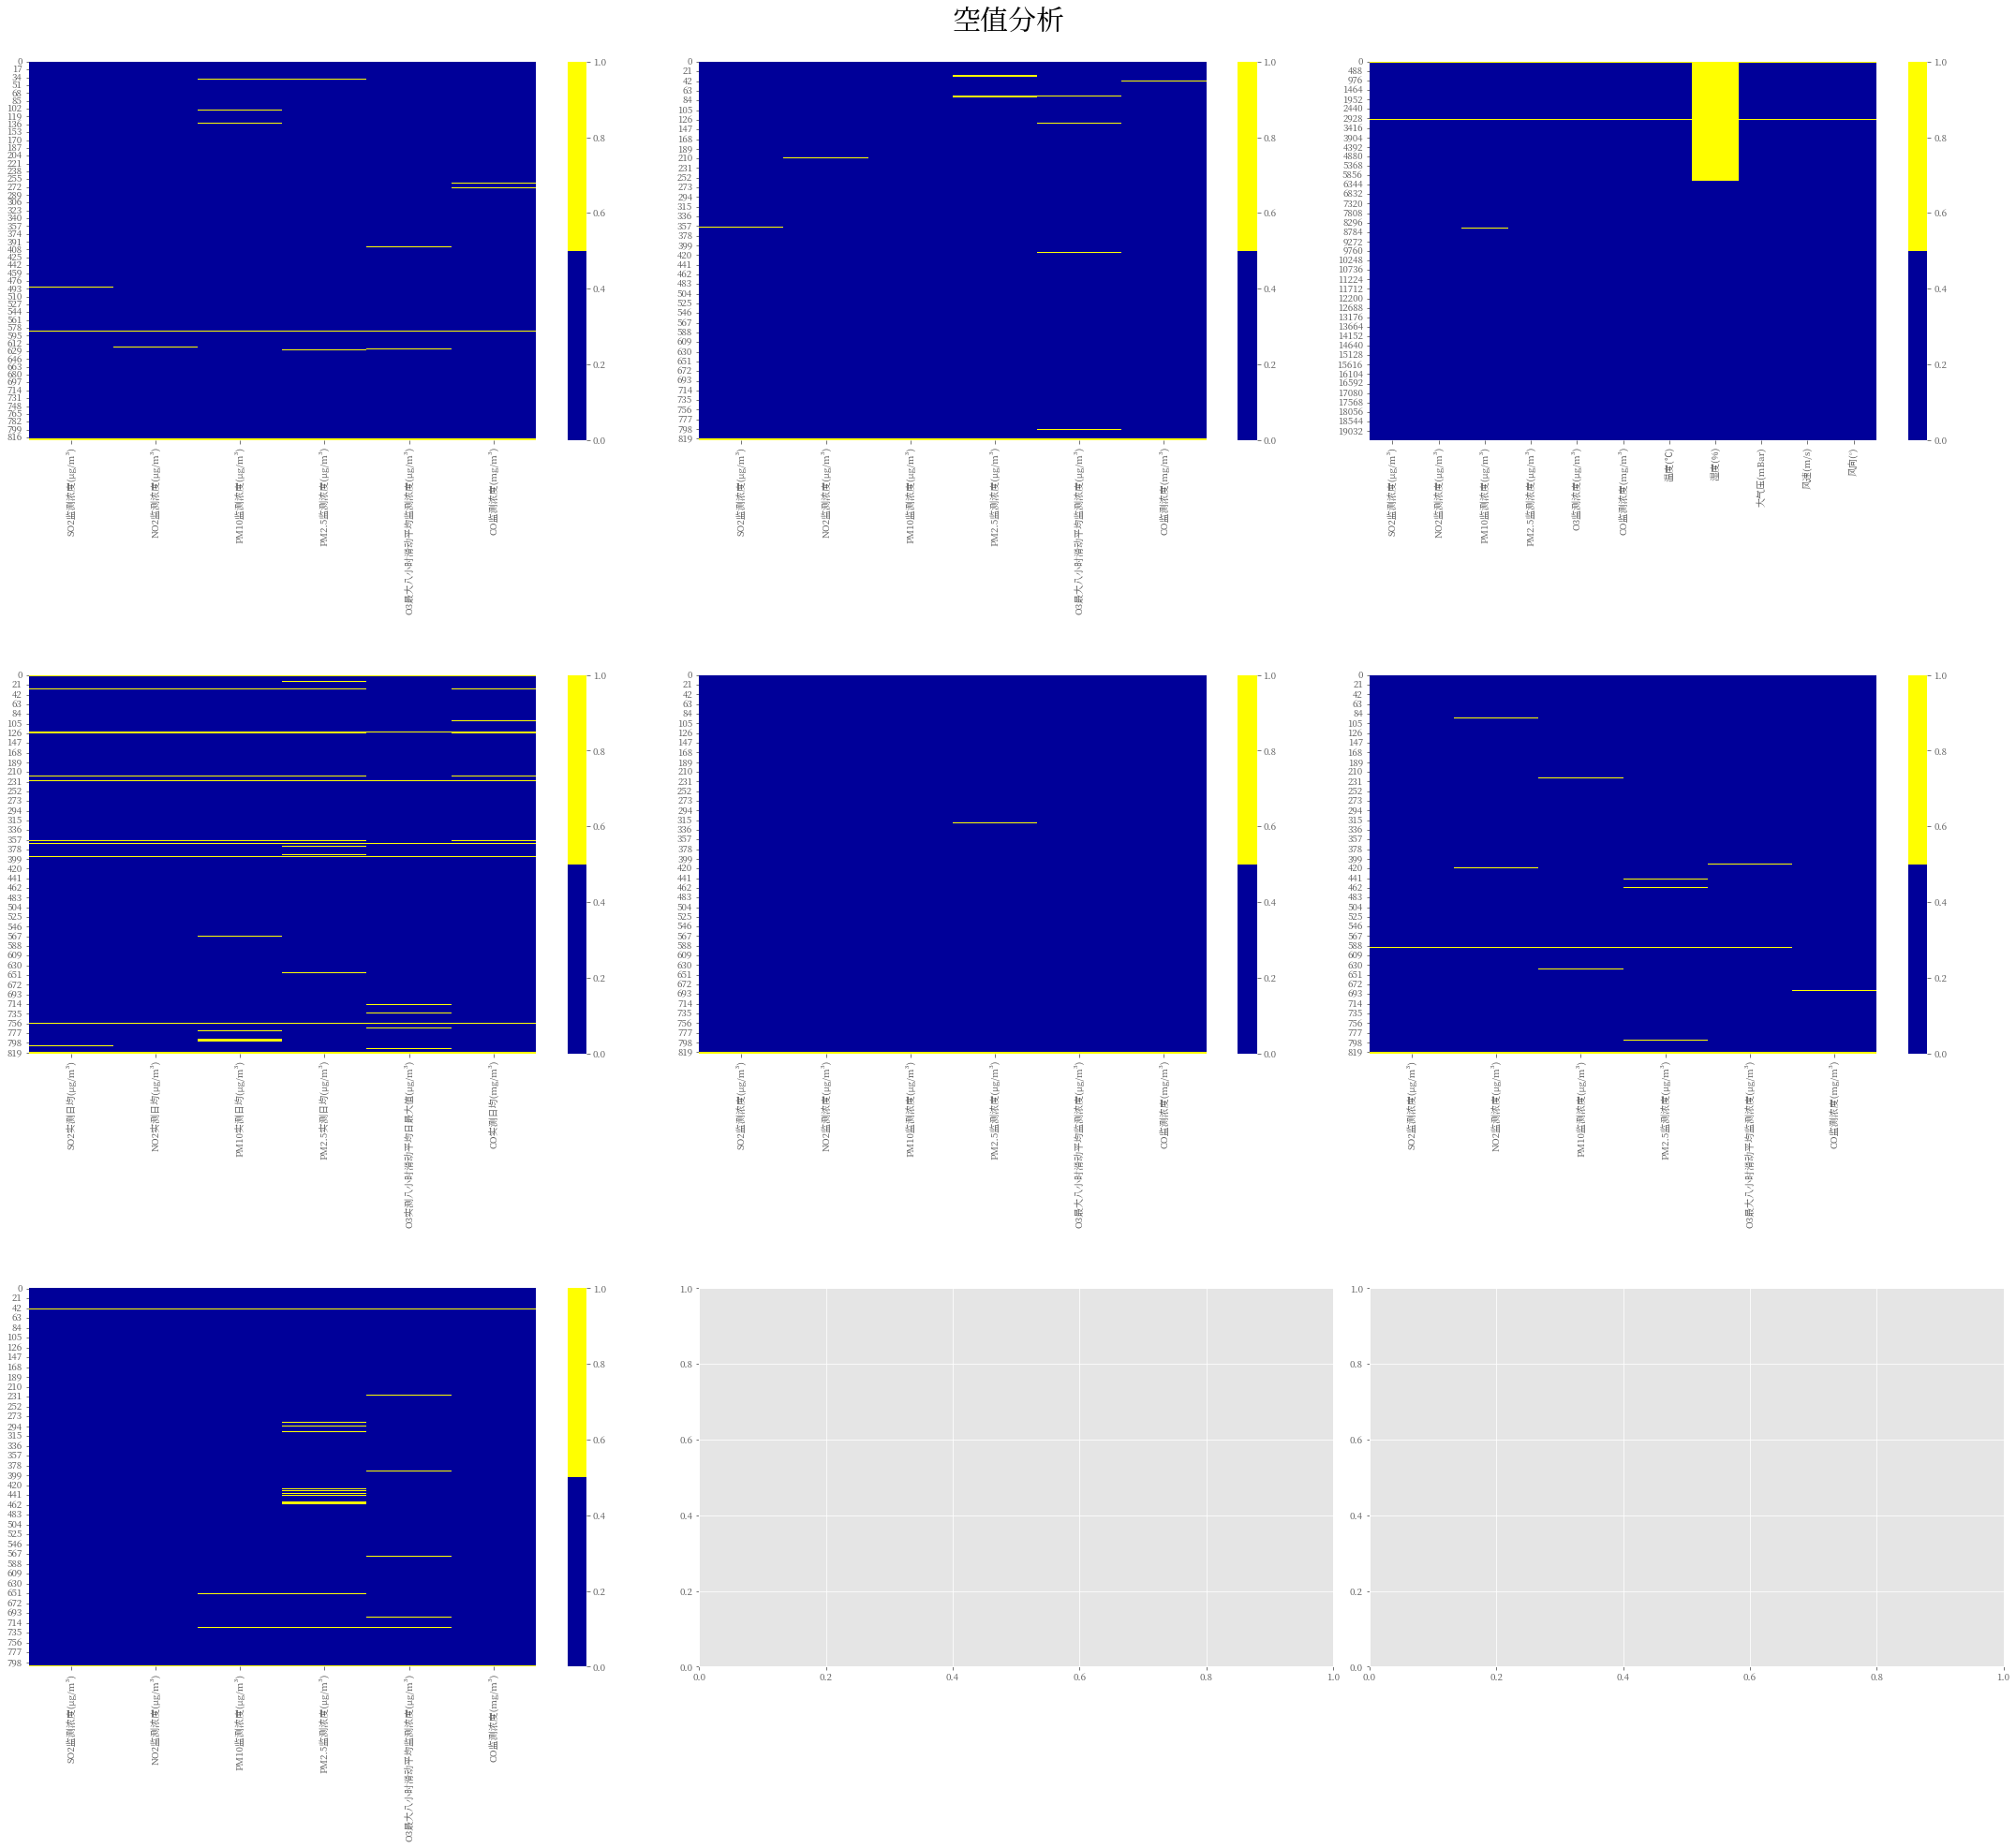

In [10]:
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.

fig, axs = plt.subplots(3, 3, figsize=FIGSIZE)
for i, n in enumerate(table_names):
    df = data[n[0]][n[1]]
    cols = df.columns[2:] # first 30 columns
    fig.suptitle('空值分析', size=30, y=1.)
    fig.tight_layout(h_pad=6)
    sns.heatmap(df[cols].isna(), cmap=sns.color_palette(colours), ax=axs[i//3][i%3])
plt.savefig("results/nan_value_analysis1."+FORMAT, format=FORMAT)
# plt.close()

## 极大值分析
通过箱形图分析离群点

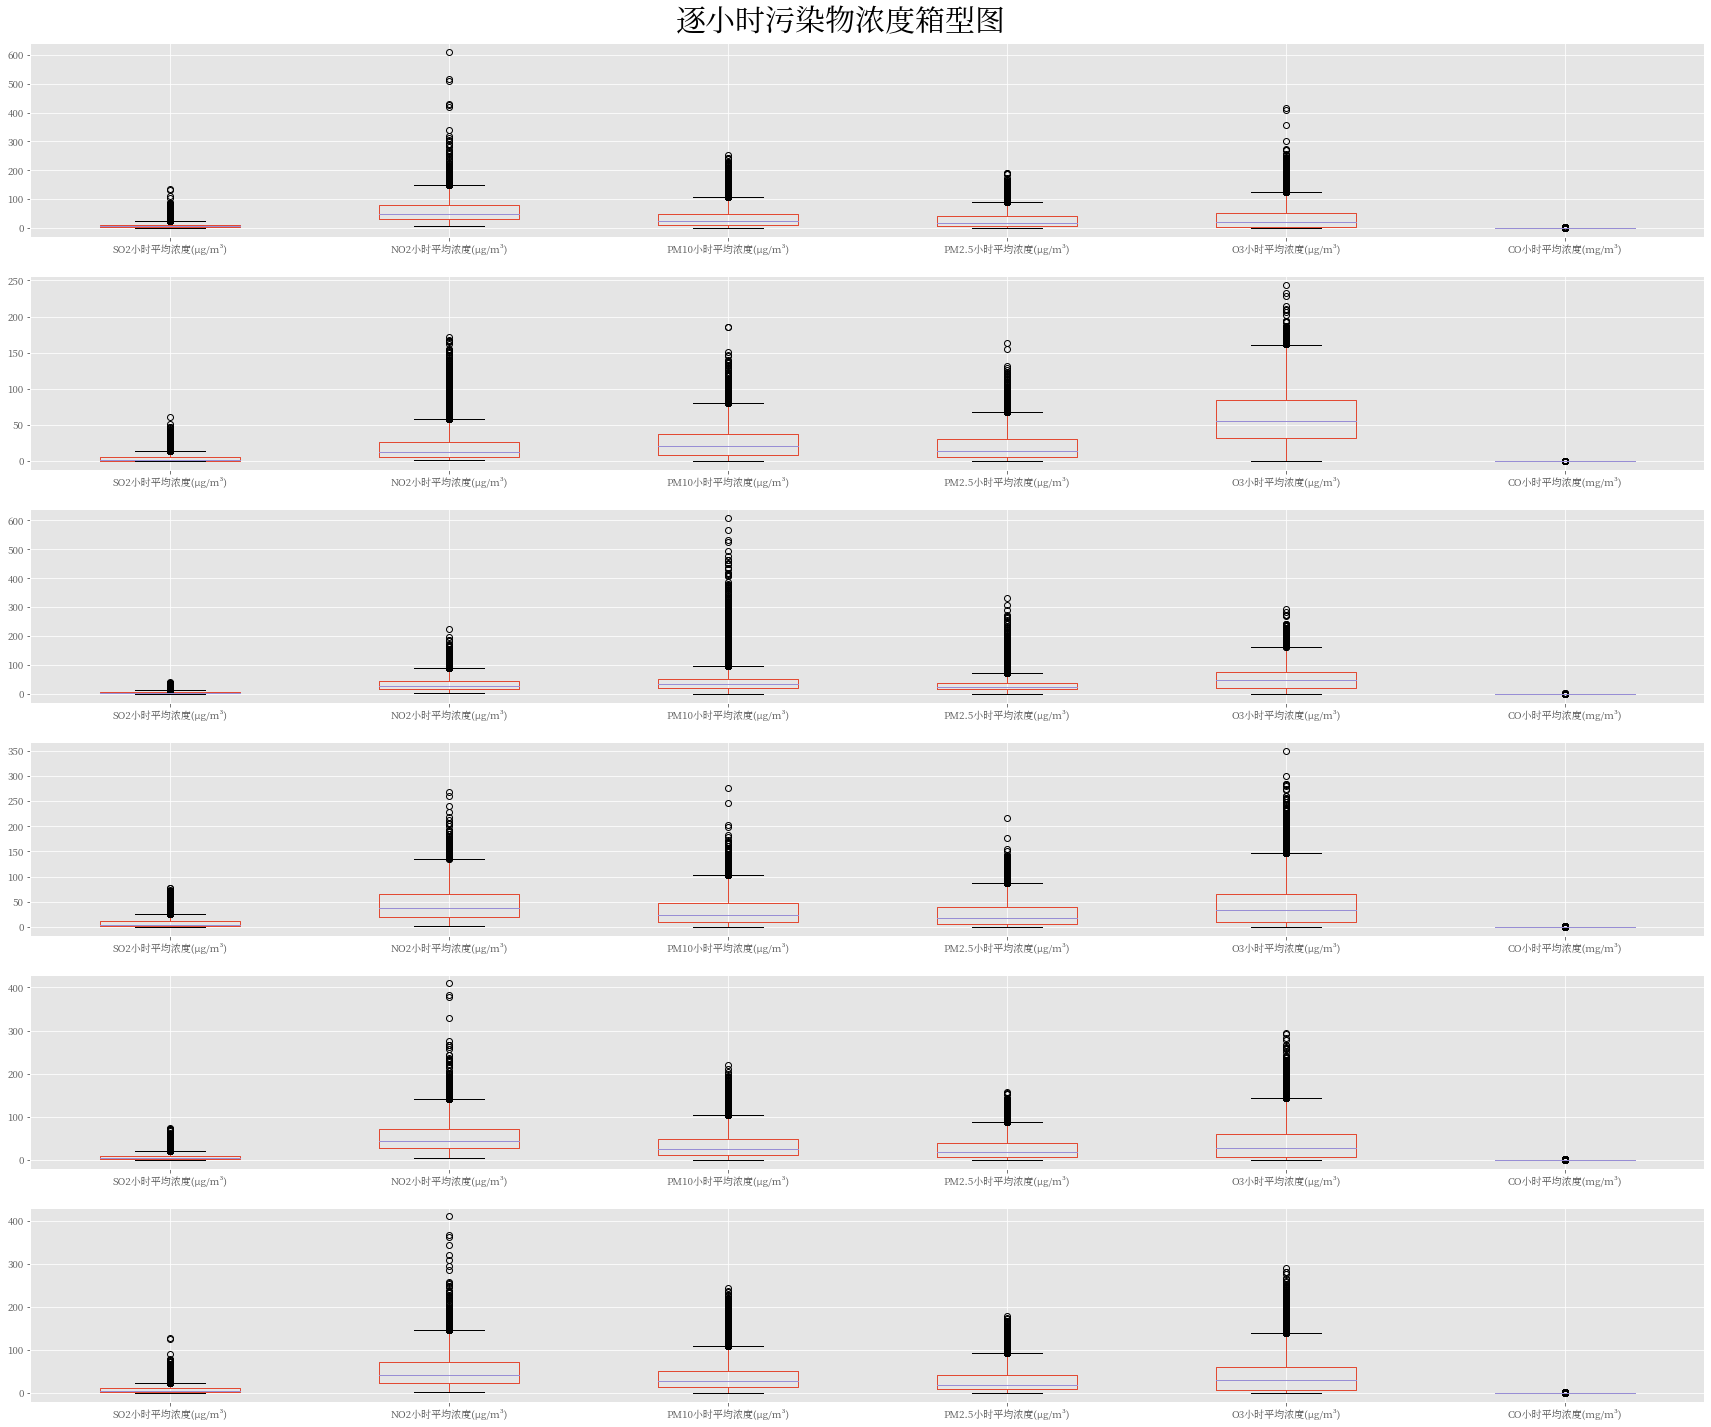

In [11]:
j=0 # 第几个表格
fig, axes = plt.subplots(nrows=len(PLACES), ncols=1, figsize=FIGSIZE)
for i, p in enumerate(PLACES):
    fig.suptitle('逐小时污染物浓度箱型图', size=30, y=0.9)
    cols = find_pollution_columns(data[p][j])
    data[p][j].boxplot(column=cols, ax=axes[i])
    
plt.savefig("results/逐小时污染物浓度箱型图0."+FORMAT, format=FORMAT)
# plt.close()

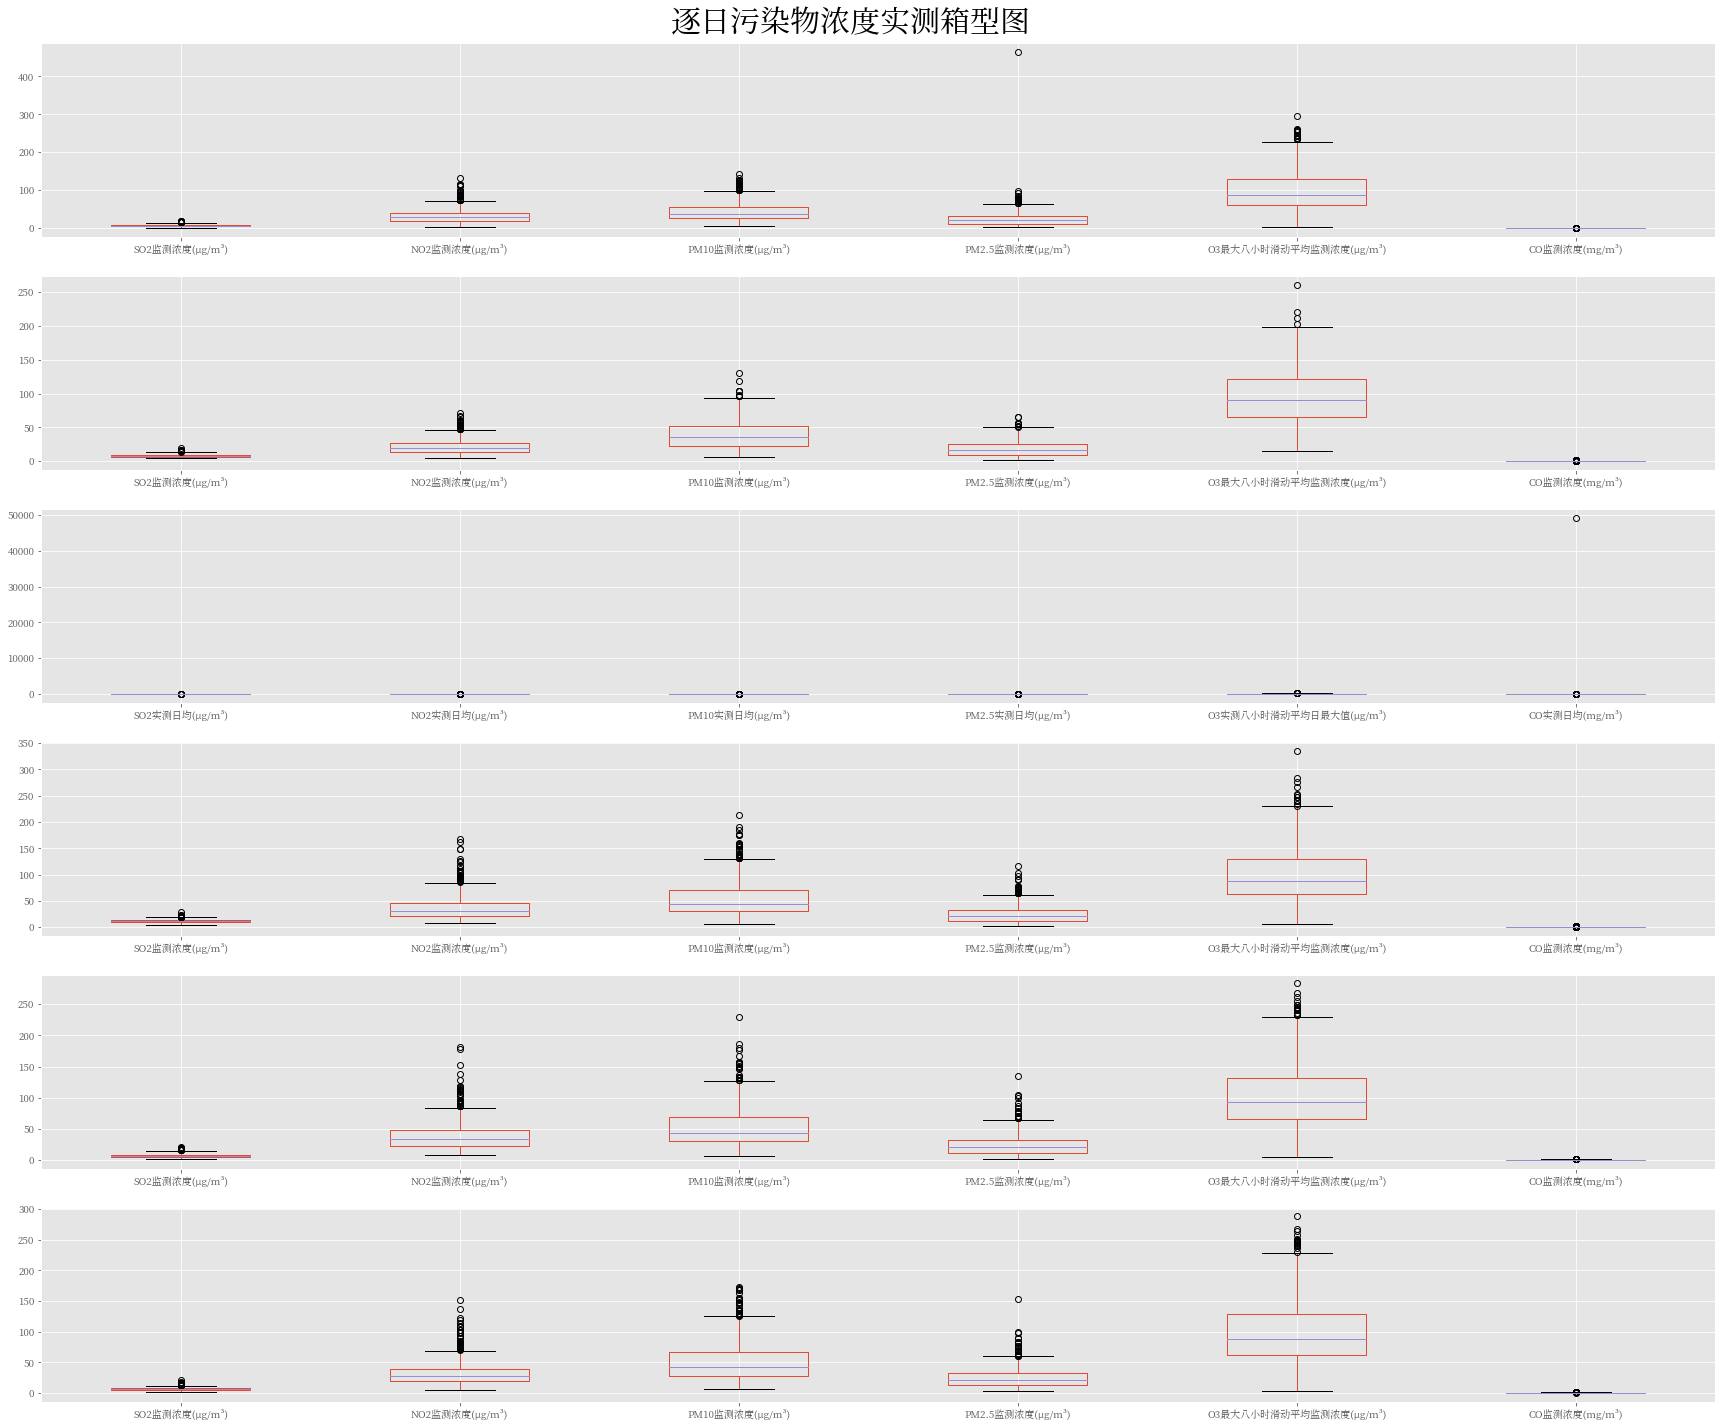

In [12]:
j=2 # 第几个表格
fig, axes = plt.subplots(nrows=len(PLACES), ncols=1, figsize=FIGSIZE)
for i, p in enumerate(PLACES):
    fig.suptitle('逐日污染物浓度实测箱型图', size=30, y=0.9)
    cols = find_pollution_columns(data[p][j])
    data[p][j].boxplot(column=cols, ax=axes[i])
    
plt.savefig("results/逐日污染物浓度实测箱型图2."+FORMAT, format=FORMAT)
# plt.close()

Text(0.5, 1, '离群点处理')

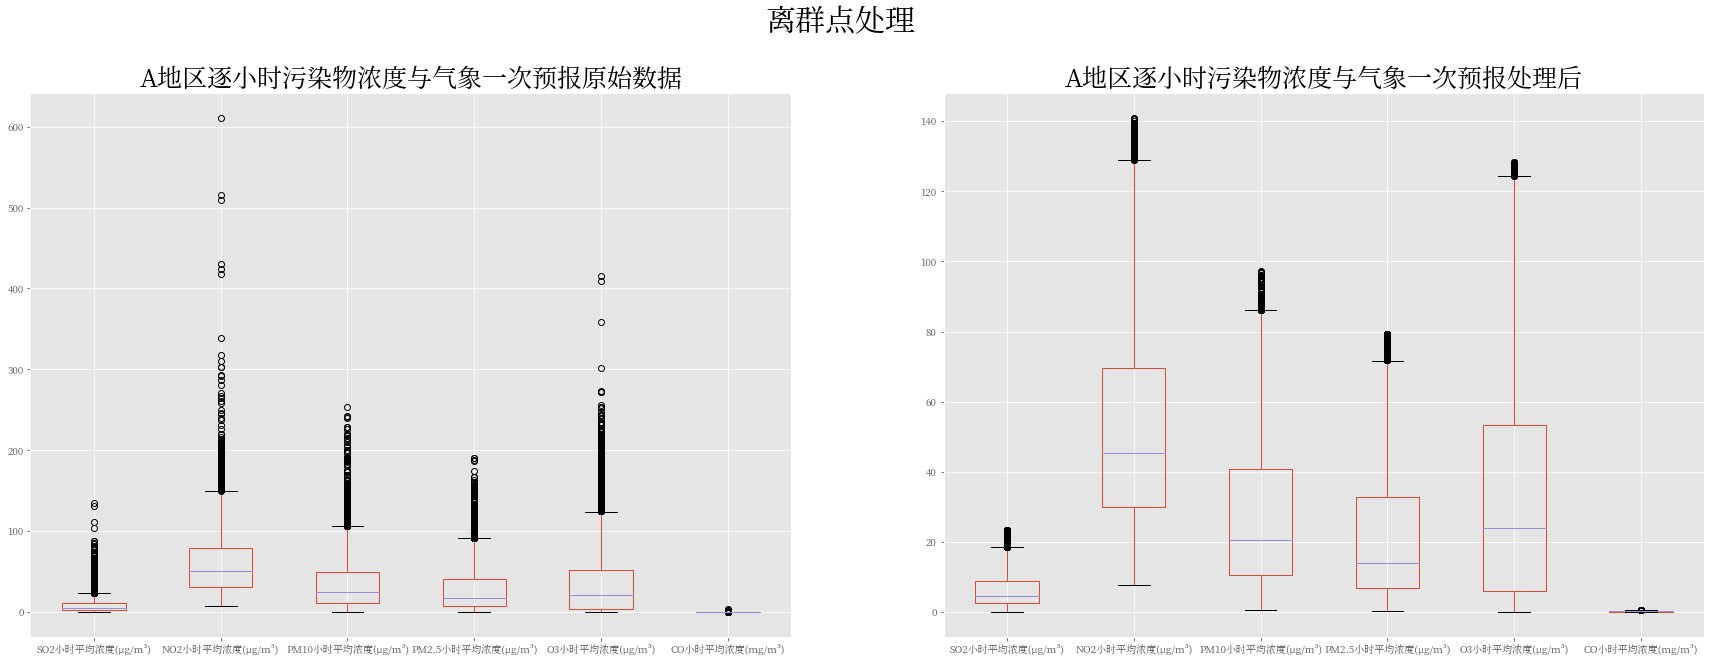

In [13]:
def remove_outlier(df_in, col_name):
    df_in[col_name] = df_in[col_name].apply(pd.to_numeric, errors='coerce')
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

def remove_outlier_from_multi_cols(df_in, col_names):
    for c in col_names:
        df_in = remove_outlier(df_in, c)
    return df_in

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
df = data['A'][0]
cols = find_pollution_columns(df)

axes[0].set_title('A地区逐小时污染物浓度与气象一次预报原始数据', size=25)
axes[1].set_title('A地区逐小时污染物浓度与气象一次预报处理后', size=25)
df.boxplot(column=cols, ax=axes[0])
cleaned_df = remove_outlier_from_multi_cols(df, cols)
cleaned_df.boxplot(column=cols, ax=axes[1])
fig.suptitle('离群点处理', size=30, y=1)

## 数据清洗
- 缺失值填充
- 负值替换


In [66]:
def create_new_table_for_place(p):
    writer = pd.ExcelWriter("../data/" + p + '.xlsx', engine='xlsxwriter')
    for i in range(3):
        df = data[p][i]
        # 数值化
        index = list(df.columns).index('地点')+1
        df1 = df[df.columns[index:]]
        # 异常值处理
        df1 = df1.apply(pd.to_numeric, errors='coerce')
        # 负值处理
        num = df1._get_numeric_data()
        num[num < 0] = np.nan
        # 空值用中位数填充
        df1 = df1.fillna(df.median(numeric_only=True))
        # 移除异常值
        # cols = find_pollution_columns(df1)
        # df1 = remove_outlier_from_multi_cols(df1, cols)
        
        df[df.columns[index:]] = df1
        df.to_excel(writer, sheet_name=str(i))
        
    writer.save()
    
for p in PLACES:
    create_new_table_for_place(p)
# create_new_table_for_place(PLACES[0])

## 预处理完分析
缺失值填充对比


In [ ]:
p,i = table_names[0]
new_df = pd.read_excel("data/{}.xlsx".format(p), engine='openpyxl', sheet_name=None)

In [33]:
null_table['A_2']

监测日期                       0
地点                         0
SO2监测浓度(μg/m³)             7
NO2监测浓度(μg/m³)             9
PM10监测浓度(μg/m³)           14
PM2.5监测浓度(μg/m³)           8
O3最大八小时滑动平均监测浓度(μg/m³)    10
CO监测浓度(mg/m³)              9
dtype: int64

In [40]:
p,i = table_names[0]
nul_cols = null_table['A_2'].keys()
# data[p][i][nul_cols]
for nc in nul_cols:
    data[p][i]["填充后-"+nc] = new_df[str(i)][nc]

In [44]:
data[p][i].columns

Index(['监测日期', '地点', 'SO2监测浓度(μg/m³)', 'NO2监测浓度(μg/m³)', 'PM10监测浓度(μg/m³)',
       'PM2.5监测浓度(μg/m³)', 'O3最大八小时滑动平均监测浓度(μg/m³)', 'CO监测浓度(mg/m³)',
       '填充后-监测日期', '填充后-地点', '填充后-SO2监测浓度(μg/m³)', '填充后-NO2监测浓度(μg/m³)',
       '填充后-PM10监测浓度(μg/m³)', '填充后-PM2.5监测浓度(μg/m³)',
       '填充后-O3最大八小时滑动平均监测浓度(μg/m³)', '填充后-CO监测浓度(mg/m³)'],
      dtype='object')

In [81]:
df['湿度(%)']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
19486     74
19487     75
19488     77
19489     78
19490     79
Name: 湿度(%), Length: 19491, dtype: object

<AxesSubplot:xlabel='监测时间', ylabel='[湿度(%)]'>

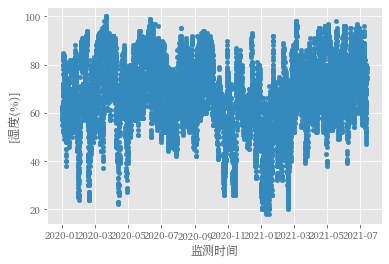

In [83]:
df = data['C'][1]
# df[~ df['湿度(%)'].isna()].plot.line(x="监测时间",y=['湿度(%)'])

c = '湿度(%)'
df[c] = pd.to_numeric(df[c], errors='coerce')
df.plot.scatter(x='监测时间', y=[c])

处理之后的箱型图

In [63]:
for p in PLACES:
    data_df = pd.read_excel("../data/{}.xlsx".format(p), engine='openpyxl', sheet_name=None)
    writer = pd.ExcelWriter("../data/" + p + '.xlsx', engine='xlsxwriter')
    for i in range(3):
        df = data_df[str(i)]
        cols = find_pollution_columns(df)
        cleaned_df = remove_outlier_from_multi_cols(df, cols)
        data_df[str(i)] = cleaned_df
    writer.save()

In [65]:
df = pd.read_excel("../data/{}.xlsx".format('A'), engine='openpyxl', sheet_name=None)
df

{'Sheet1': Empty DataFrame
 Columns: []
 Index: []}

KeyError: '0'

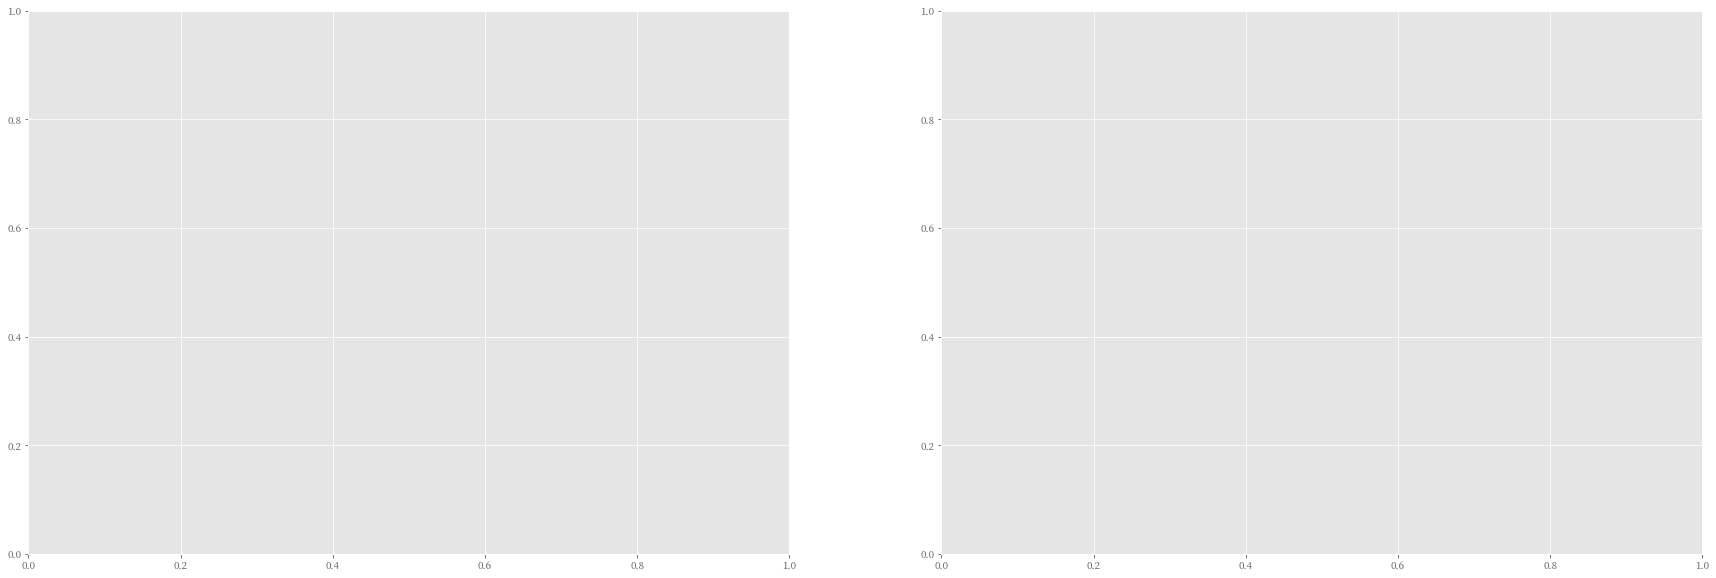

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
df = pd.read_excel("../data/{}.xlsx".format('A'), engine='openpyxl', sheet_name=None)['0']
cols = find_pollution_columns(df)

axes[0].set_title('A地区逐小时污染物浓度与气象一次预报原始数据', size=25)
axes[1].set_title('A地区逐小时污染物浓度与气象一次预报处理后', size=25)
df.boxplot(column=cols, ax=axes[0])
cleaned_df = remove_outlier_from_multi_cols(df, cols)
cleaned_df.boxplot(column=cols, ax=axes[1])

<AxesSubplot:>

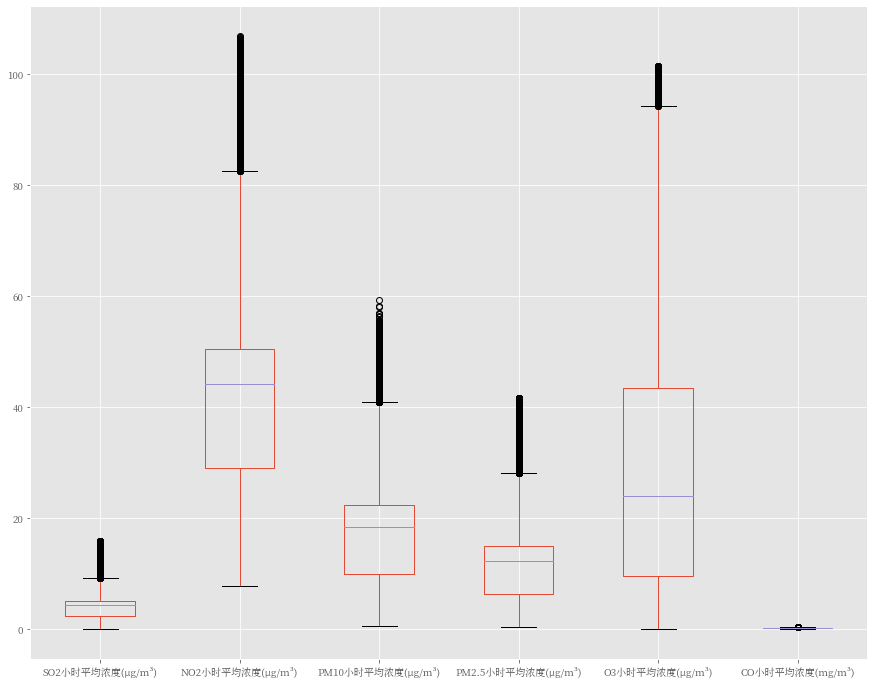

In [233]:
df = pd.read_excel("../data/{}.xlsx".format('A'), engine='openpyxl', sheet_name=None)['0']
cols = find_pollution_columns(df)
df.boxplot(column=cols, figsize=(15,12))

In [234]:
for p in PLACES:
    df = pd.read_excel("../data/{}.xlsx".format(p), engine='openpyxl', sheet_name=None)
    for i in range(3):
        num = df[str(i)]._get_numeric_data()
        if (num<0).sum().sum() != 0:
            print(p,i)

# 数据分析
下面首先对各量随时间的分布进行分析
注意数字和子表格的对应：
- 0 逐小时污染物浓度与气象一次预报数据
- 1 逐小时污染物浓度与气象实测数据
- 2 逐日污染物浓度实测数据

## 0 对逐小时污染物浓度与气象一次预报数据的分析

In [ ]:
key = data['A'][0].columns
key, len(key[3:])

In [ ]:
PREDICTED_KEYS = key[3:]
print("预测天气状况",PREDICTED_KEYS[:-6])
print("预测污染因素",PREDICTED_KEYS[-6:])

In [ ]:
def plot_prediction_hist_by_time(place):
    "对逐小时污染物浓度与气象一次预报数据的分析"
    key = data[place][0].columns
    PREDICTED_KEYS = key[3:]
    fig, axes = plt.subplots(nrows=7, ncols=3, figsize=FIGSIZE)
    fig.tight_layout(h_pad=3)
    plt.suptitle(place+"_0", size=30)
    
    for i, k in enumerate(PREDICTED_KEYS):
        data[place][0].plot.line(ax = axes[i//3][i%3], x = key[1] , y=k)
    plt.savefig("results/{}_0逐小时污染物浓度与气象一次预报数据.{}".format(place, FORMAT), format=FORMAT)
    plt.close()


for p in PLACES:
    plot_prediction_hist_by_time(p)

## 1 对逐小时污染物浓度与气象实测数据的分析

In [ ]:
key = data['A'][1].columns
key, len(key[2:])

In [ ]:
MEASURED_KEYS = key[2:]
print("测量天气状况",MEASURED_KEYS[:6])
print("测量污染因素",MEASURED_KEYS[6:])

In [ ]:
def plot_measured_hist_by_hour(place):
    "对逐小时污染物浓度与气象一次预报数据的分析"
    key = data[place][1].columns
    MEASURED_KEYS = key[2:]
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=FIGSIZE)
    for i, k in enumerate(MEASURED_KEYS):
        axes[i//3][i%3].set_xticks([])
        # 预处理
        data[place][1][k].fillna(0)
        # 将object类型转为数值类型
        data[place][1][k] = pd.to_numeric(data[place][1][k], errors='coerce')
        data[place][1].plot.line(ax = axes[i//3][i%3], x = key[0] , y=k)
    fig.tight_layout(h_pad=3)
    plt.suptitle(place+"_1", size=30)
    plt.savefig("results/{}_1逐小时污染物浓度与气象实测数据.{}".format(place, FORMAT), format=FORMAT)
    plt.close()
    
for p in PLACES:
    plot_measured_hist_by_hour(p)

## 2 对逐日污染物浓度实测数据的分析

In [ ]:
key = data['A'][2].columns
key, len(key[2:])

In [ ]:
MEASURED_KEYS = key[2:]
print("测量污染因素",MEASURED_KEYS[:])

In [ ]:
def plot_measured_polution_hist_by_day(place):
    "对逐小时污染物浓度与气象一次预报数据的分析"
    key = data[place][2].columns
    MEASURED_KEYS = key[2:]
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=FIGSIZE)
    for i, k in enumerate(MEASURED_KEYS):
        # 预处理
        data[place][2][k].fillna(0)
        # 将object类型转为数值类型
        data[place][2][k] = pd.to_numeric(data[place][2][k], errors='coerce')
        data[place][2].plot.line(ax = axes[i//3][i%3], x = key[0] , y=k)
    fig.tight_layout(h_pad=3)
    plt.suptitle(place+"_2", size=30)
    plt.savefig("results/{}_2逐日污染物浓度实测数据.{}".format(place, FORMAT), format=FORMAT)
    plt.close()
# 解锁运行  
for p in PLACES:
    plot_measured_polution_hist_by_day(p)